# Libraries

In [5]:
import os
import glob
import chardet
from IPython.core import display as ICD
from tqdm.notebook import tqdm


# visualisation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['savefig.facecolor'] = "0.8"
plt.rcParams.update({'figure.figsize': (15, 5), 'figure.dpi': 120})
plt.style.use('fivethirtyeight')

# preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data fetching / parsing

In [6]:
def data_fetch_parse(path: str) -> dict:
    # Get CSV files list from a folder
    csv_files = glob.glob(path + "/*.csv")
    csv_files_name = [file for file in os.listdir(path) if file.endswith(".csv")]
    # Read each CSV file into DataFrame
    # This creates a list of dataframes
    df_list = {}
    for file, file_name in zip(csv_files, csv_files_name):
        # Look at the first ten thousand bytes to guess the character encoding with confidence interval
        with open(file, 'rb') as rawdata:
            encod_type = chardet.detect(rawdata.read(10000))["encoding"]
            df = pd.read_csv(file, sep=None, delim_whitespace=None, encoding=encod_type, engine="python")  # parse data with given file path
            if set(["SK_ID_CURR"]).issubset(df.columns):
                df = df.drop("SK_ID_CURR", axis=1)
                df_list[file_name] = df
            else:
                df_list[file_name] = df

    return df_list

In [10]:
local_path = "../data/csv/train_test"
df_fetched = data_fetch_parse(path=local_path)

In [11]:
TRAIN, TEST = df_fetched["application_train.csv"], df_fetched["application_test.csv"]

In [14]:
TRAIN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 121 entries, TARGET to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 283.9+ MB


In [200]:
TRAIN.describe()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,3522.886321,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,-7479.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,-4504.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,-2010.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


# Data visualization

## Categorical variables

In [12]:
def ctg_analysis(data: pd.DataFrame, target_only=False):
    df = data.copy()  # define variable as a copy of given dateset

    # Set target variable
    target = df["TARGET"]
    # Select categorical variables only
    df = df[df.select_dtypes(include=['object']).columns]

    # Drop target feature from categorical features list
    # df = df.drop("TARGET", axis=1)

    if target_only:
       sns.countplot(x=target, data=df)
       plt.suptitle(f"Target feature variables distribution") 
       ICD.display(target.value_counts())
    else:
        # Count plot categorical features
        fig, axes = plt.subplots(int(len(df.columns) / 2), 2, figsize=(35, 35), sharex="all", constrained_layout=True) 

        for i, ax in zip(range(len(df.columns)), axes.ravel()):
            sns.countplot(y=df.columns[i], data=df, hue=target, ax=ax)
            ax.set(ylabel="Categories",
                    xlabel="Number of clients",
                    title= f"Categorical distribution for \n {df.columns[i]}")
            ax.xaxis.set_tick_params(labelbottom=True) # set label ticks per ax
            ax.tick_params(axis="y", labelsize=8)

    # set spacing for every subplot, else x-axis will be covered
    plt.tight_layout()

    # export report figure
    plt.savefig(f"../reports/eda/ctg_count_plot.png")

In [176]:
ctg_analysis(TRAIN)

0    282686
1     24825
Name: TARGET, dtype: int64

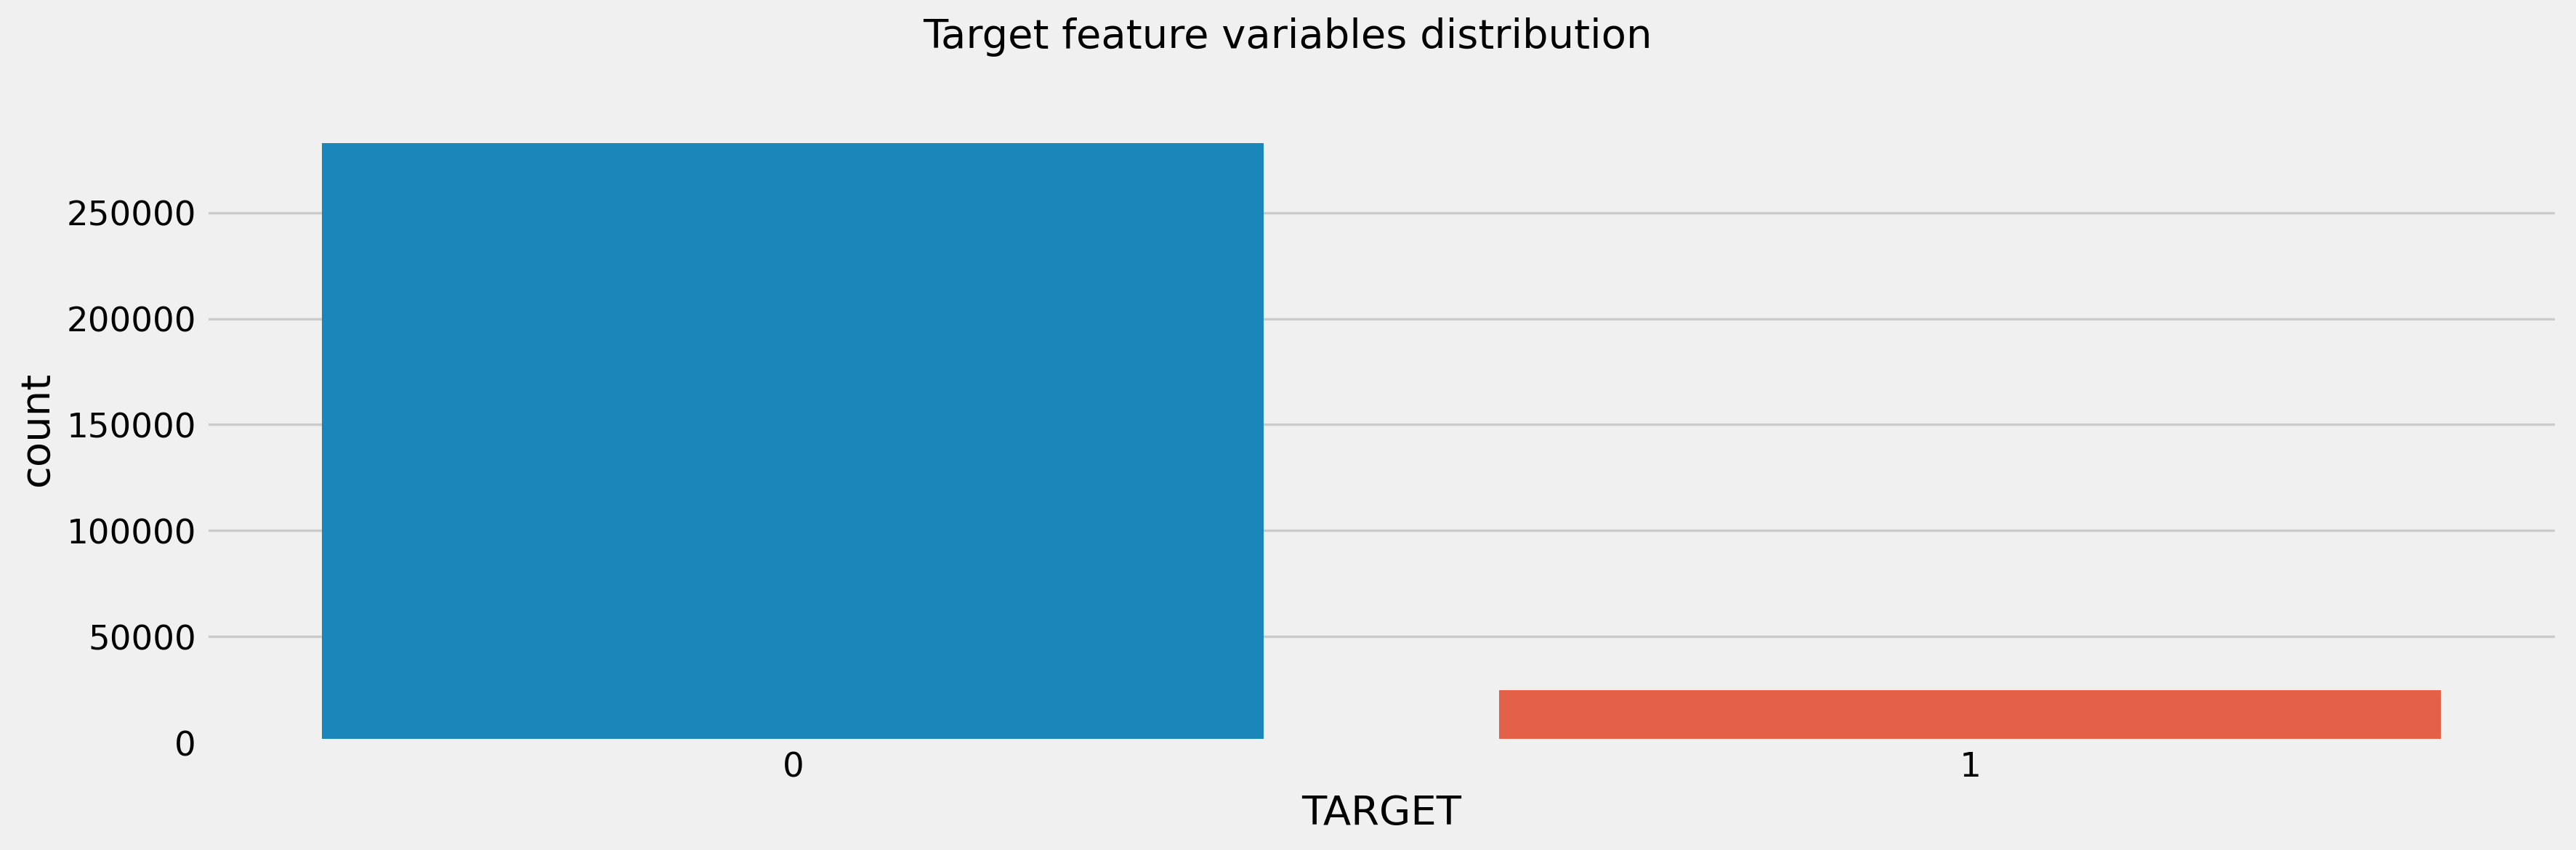

In [13]:
ctg_analysis(TRAIN, target_only=True)

## Discrete variables

In [18]:
def num_analysis(data: pd.DataFrame, plot_type: str):
    df = data.copy()  # define variable as a copy of given dateset

    # Set target variable
    target = df["TARGET"]

    # Select numerical discrete/continous variables only
    df = df._get_numeric_data()

    # Drop target feature from categorical features list
    # df = df.drop("TARGET", axis=1)

    # Count plot categorical features
    fig, axes = plt.subplots(int(len(df.columns) / 2), 2, figsize=(50, 50), sharex="all", constrained_layout=True)

    for i, ax in zip(range(len(df.columns)), axes.ravel()):
        if plot_type == "box-plot":
            sns.boxplot(x=target, y=df.columns[i], data=df, ax=ax)
            ax.set(ylabel="Status",
                    xlabel="Number of clients",
                    title= f"Numeric distribution for \n {df.columns[i]}")
            ax.xaxis.set_tick_params(labelbottom=True) # set label ticks per ax
            ax.tick_params(axis="y", labelsize=8)

            # set spacing for every subplot, else x-axis will be covered
            plt.tight_layout()

            # export report figure
            plt.savefig(f"../reports/eda/num_boxplots.png")

        elif plot_type == "kde-plot":
            sns.kdeplot(data=df, x=df.columns[i], hue=target, ax=ax)
            ax.set(ylabel="Status",
                    xlabel="Number of clients",
                    title= f"Numeric distribution for \n {df.columns[i]}")
            ax.xaxis.set_tick_params(labelbottom=True) # set label ticks per ax
            ax.tick_params(axis="y", labelsize=8)

            # set spacing for every subplot, else x-axis will be covered
            plt.tight_layout()

            # export report figure
            plt.savefig(f"../reports/eda/num_dists.png")


In [ ]:
num_analysis(TRAIN, plot_type="box-plot")

## Correlation

In [58]:
def plot_corr(data): 
    df = data.copy()
    # df = df.drop("TARGET") 

    categorical_fts = df.select_dtypes(include=['object']).columns

    # Encode categorical features for heatmap plotting
    for col in categorical_fts:
        df[col] = LabelEncoder().fit_transform(df[col])

    # heatmap plot features -> target correlation
    sns.heatmap(df.corr()[["TARGET"]].sort_values("TARGET").tail(10), vmax=1, vmin=-1, annot=True)

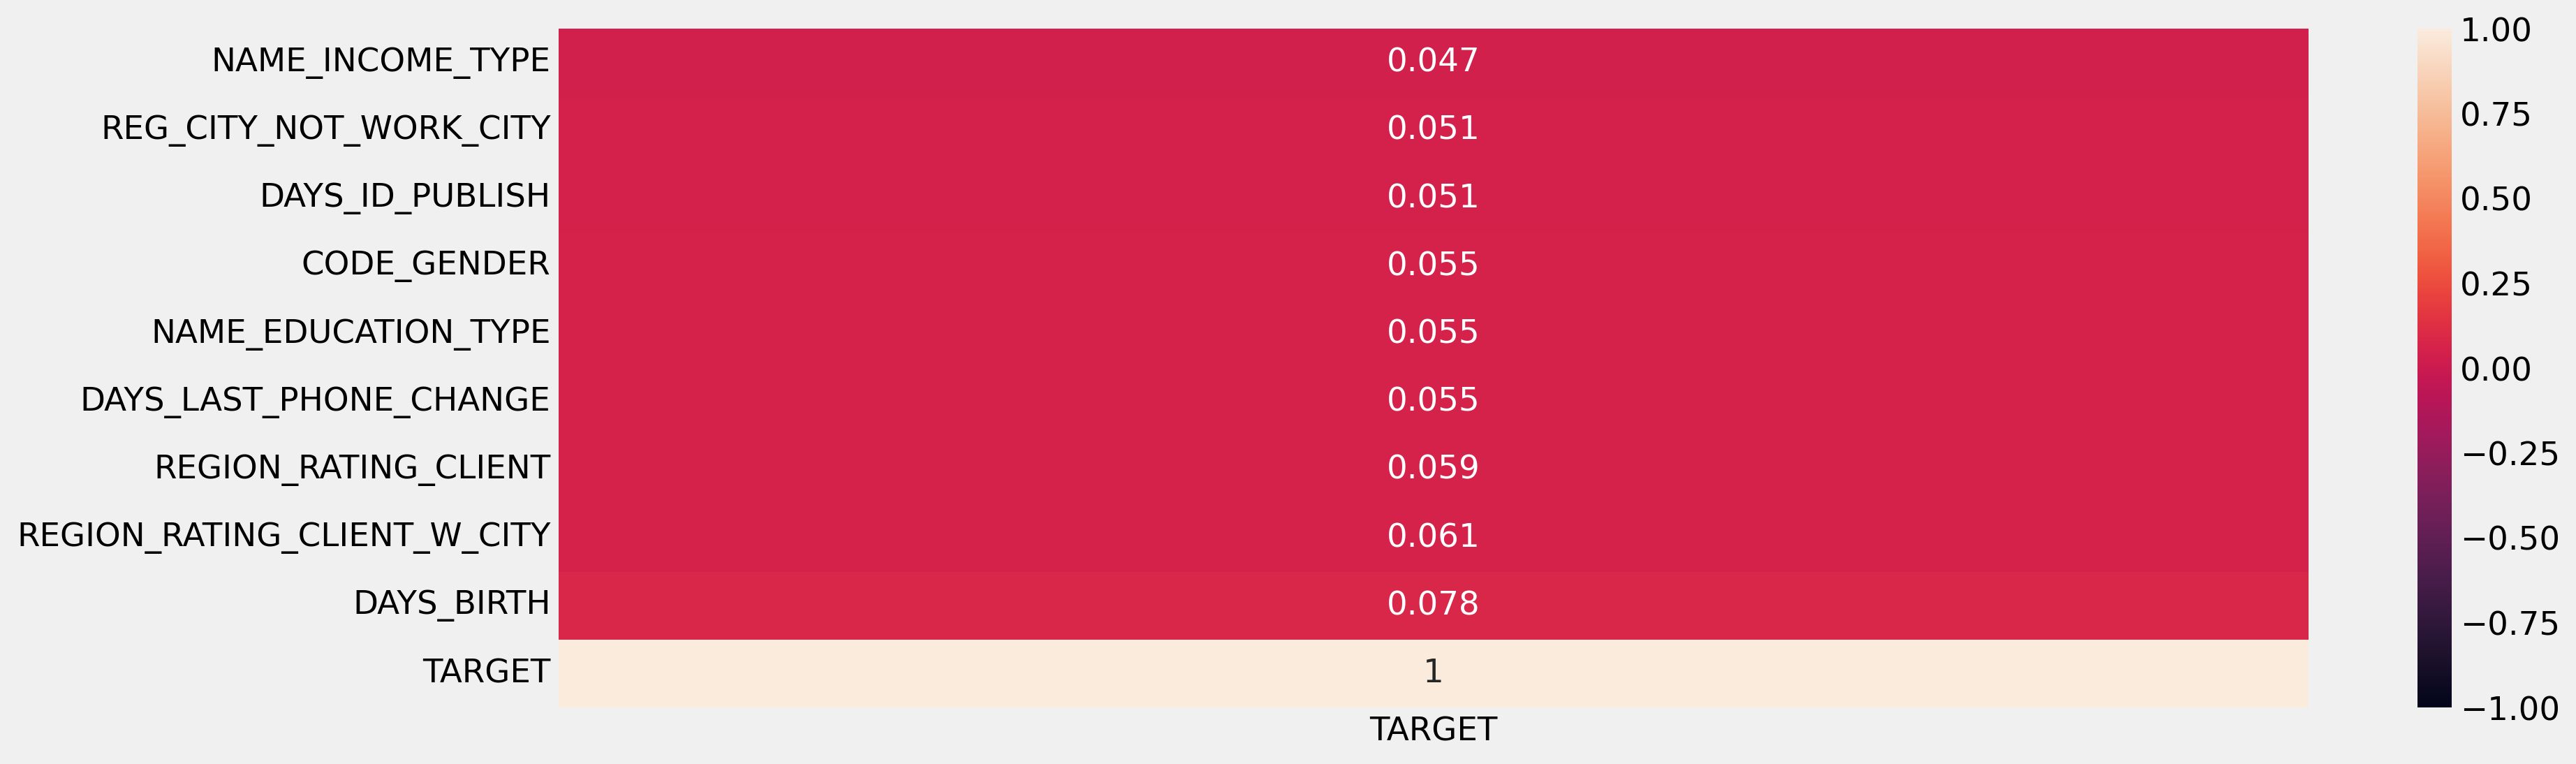

In [59]:
plot_corr(TRAIN)

-----------------

## Summary & first conclusions

### Data fetching
- There are many csv files including a meta-data header explaining csv and two files named / given as train and test set.
- Those files are all UTF-8 encoded, except for the meta-data file which is "Windows-1252" format encoded.
- Remaining files are extra-detailed clients informations.

### Data exploration
- Train / test have each one 307511 and 48744 instances (rows) and 120 attributes, and target header containing credit score labels (0 - term loan demand aceepted | 1 - term loan rejected because of financial difficulties / missed payments).
- Attributes such as client_id and sex had been dropped for privacy / non discrimination policy.

### Data visualization
#### Categorical features
##### Count plot 
- Work in progress
- Classes are strongly unbalanced | 92% against 8% 
#### Correlation
- Most of features are nearly not correlated with the target, only client's birth day has a considerable positive correlation of 7.8%.

---------------------------